<a href="https://colab.research.google.com/github/ftk1000/colab_demos/blob/master/text_classification_with_python_and_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

* Data Set
* Defining a Baseline Model
* Introduction to Deep Neural Networks
    * Introducing Keras
    * First Keras Model
* What Is a Word Embedding?
     * One-Hot Encoding
     * Word Embeddings
     * Keras Embedding Layer
* Convolutional Neural Networks (CNN)
*  Hyperparameters Optimization

### Importing Packages

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import os, time
# print(os.listdir("../input"))


# PULL DATA FROM KAGGLE

In [54]:
!pip install kaggle

In [55]:
from google.colab import files
files.upload()

Saving kaggle_20200901.json to kaggle_20200901 (1).json


{'kaggle_20200901.json': b'{"username":"zurman","key":"09a91dfb7e3922f4f752e77ff3733b27"}'}

In [56]:
!mkdir -p ~/.kaggle
!cp kaggle_20200901.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [57]:
# !wget https://github.com/ftk1000/data_files/textclassificationdb.zip

# DOWNLOAD textclassificationdb.zip
# !kaggle datasets download -d luishpinto/textclassificationdb

In [58]:
!kaggle datasets download -d luishpinto/textclassificationdb

textclassificationdb.zip: Skipping, found more recently modified local copy (use --force to force download)


In [59]:
from zipfile import ZipFile
file_name = "textclassificationdb.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [60]:
!head -10 amazon_cells_labelled.txt
!pwd

So there is no way for me to plug it in here in the US unless I go by a converter.	0
Good case, Excellent value.	1
Great for the jawbone.	1
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
The mic is great.	1
I have to jiggle the plug to get it to line up right to get decent volume.	0
If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.	0
If you are Razr owner...you must have this!	1
Needless to say, I wasted my money.	0
What a waste of money and time!.	0
/content


In [61]:
#!ls -la ../input/sentiment\ labelled\ sentences 
# !ls -la /kaggle/input/sentiment\ labelled\ sentences 
!ls -l

total 300
-rw-r--r-- 1 root root 58226 Sep  4 16:48  amazon_cells_labelled.txt
-rw-r--r-- 1 root root 85285 Sep  4 16:48  imdb_labelled.txt
-rw-r--r-- 1 root root    62 Sep  4 16:48 'kaggle_20200901 (1).json'
-rw-r--r-- 1 root root    62 Sep  4 15:59  kaggle_20200901.json
drwxr-xr-x 1 root root  4096 Aug 27 16:39  sample_data
-rw-r--r-- 1 root root 82239 Sep  4 15:59  textclassificationdb.zip
-rw-r--r-- 1 root root 61320 Sep  4 16:48  yelp_labelled.txt


In [62]:
# !cp /kaggle/input/sentiment\ labelled\ sentences/*.txt www.kaggle.com/zurman/


Extract the folder into a data folder and go ahead and load the data with Pandas:

In [63]:
# https://www.kaggle.com/zurman/text-classification-with-python-and-keras/edit
import pandas as pd

filepath_dict = {'yelp':   'yelp_labelled.txt', #../input/sentiment labelled sentences/sentiment labelled sentences/
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)
# df_list

In [64]:
df_list

[                                              sentence  label source
 0                             Wow... Loved this place.      1   yelp
 1                                   Crust is not good.      0   yelp
 2            Not tasty and the texture was just nasty.      0   yelp
 3    Stopped by during the late May bank holiday of...      1   yelp
 4    The selection on the menu was great and so wer...      1   yelp
 ..                                                 ...    ...    ...
 995  I think food should have flavor and texture an...      0   yelp
 996                           Appetite instantly gone.      0   yelp
 997  Overall I was not impressed and would not go b...      0   yelp
 998  The whole experience was underwhelming, and I ...      0   yelp
 999  Then, as if I hadn't wasted enough of my life ...      0   yelp
 
 [1000 rows x 3 columns],
                                               sentence  label  source
 0    So there is no way for me to plug it in here i...      

In [65]:
df = pd.concat(df_list)
df.iloc[0]

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object

In [66]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [67]:
df.tail()

,sentence,label,source
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb
747,All in all its an insult to one's intelligence...,0,imdb


Now use the `CountVectorizer` provided by the `scikit-learn` library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

In [68]:
# !pip install scikit-learn

In [69]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [70]:
sentences = ['Masha likes ice cream', 'Masha hates chocolate.']

In [71]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'Masha': 0, 'chocolate': 1, 'cream': 2, 'hates': 3, 'ice': 4, 'likes': 5}

In [72]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

## Defining a Baseline Model

First, you are going to split the data into a training and testing set which will allow you to evaluate the accuracy and see if your model generalizes well. This means whether the model is able to perform well on data it has not seen before. This is a way to see if the model is overfitting.

**Overfitting** is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data. 

We start by taking the Yelp data set which we extract from our concatenated data set. From there, we take the sentences and labels.

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [75]:
df_yelp.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [76]:
print(df_yelp['label'].value_counts())

1    500
0    500
Name: label, dtype: int64


Create the feature vectors for each sentence of the training and testing set:

In [77]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [78]:
print(type(X_train))
vocab = vectorizer.vocabulary_
print('VOCAB LENGTH = ',len(vectorizer.vocabulary_))

# show 10 vocab entries
highestCount = max(vocab.values())
for k, v in vocab.items():
  if v <= highestCount and v > highestCount-10 :
    print(v,k)

<class 'scipy.sparse.csr.csr_matrix'>
VOCAB LENGTH =  1714
1707 you
1709 yucky
1708 your
1711 yum
1706 yet
1712 yummy
1713 zero
1704 yellow
1705 yellowtail
1710 yukon


`CountVectorizer` performs tokenization which separates the sentences into a set of **tokens**. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

The classification model we are going to use is the logistic regression which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (by default 0.5), the regression model is used for classification. 

In [79]:
from sklearn.linear_model import LogisticRegression
import time


# in this DF we will track DATASET, TRAINING_run_time and ACCURACY for each MODEL
resdf = pd.DataFrame(columns=['model','dataset','Train_Runtime','accuracy'])
idx=0
resdf

,model,dataset,Train_Runtime,accuracy


In [80]:
start_time = time.time()
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
rtime = time.time() - start_time 
# print("Accuracy:", score)
resdf.loc[idx]=['lr','yelp', rtime, score]
idx+=1
resdf

,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796


In [81]:
# start_time = time.time()
# rtime = time.time() - start_time 
# # print("Accuracy:", score)
# resdf.loc[idx]=['lr',rtime, score]
# idx+=1
# resdf
idx

1

You can see that the logistic regression reached an impressive 79.6%, but let’s have a look how this model performs on the other data sets that we have. In this script, we perform and evaluate the whole process for each data set that we have:

In [82]:
df.shape

(2748, 3)

In [83]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)

    if source!='yelp':
          resdf.loc[idx]=['lr',source, 'NA', score]
          idx+=1

    print('T_train_shape',X_train.shape)      
    print('T_test_shape',X_test.shape)      
    print('Accuracy for {} data: {:.4f}'.format(source, score))
    print("\n")


T_train_shape (750, 1714)
T_test_shape (250, 1714)
Accuracy for yelp data: 0.7960


T_train_shape (750, 1546)
T_test_shape (250, 1546)
Accuracy for amazon data: 0.7960


T_train_shape (561, 2505)
T_test_shape (187, 2505)
Accuracy for imdb data: 0.7487




In [84]:
resdf

,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796000
1,lr,amazon,NA,0.796000
2,lr,imdb,NA,0.748663


Great! You can see that this fairly simple model achieves a fairly good accuracy.

## Introduction to Deep Neural Networks
**Neural networks**, or sometimes called **artificial neural network (ANN)** or**feedforward neural network**, are computational networks which were vaguely inspired by the neural networks in the human brain. They consist of neurons (also called nodes) which are connected like in the graph below.

You start by having a layer of input neurons where you feed in your feature vectors and the values are then feeded forward to a hidden layer. At each connection, you are feeding the value forward, while the value is multiplied by a weight and a bias is added to the value. This happens at every connection and at the end you reach an output layer with one or more output nodes.

If you want to have a binary classification you can use one node, but if you have multiple categories you should use multiple nodes for each category:

### Introducing Keras

Keras is a deep learning and neural networks API by François Chollet which is capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft). To quote the wonderful book by François Chollet, Deep Learning with Python:

    Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn’t handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras (Source)

It is a great way to start experimenting with neural networks without having to implement every layer and piece on your own. For example Tensorflow is a great machine learning library, but you have to implement a lot of boilerplate code to have a model running.

### First Keras Model

Keras supports two main types of models. You have the Sequential model API and the functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Before we build our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. In order to build the Sequential model, you can add layers one by one in order

In [85]:
import keras
from keras import Sequential

In [86]:
X_train.shape

(561, 2505)

In [87]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [88]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [89]:
start_time = time.time()

history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

rtime = time.time() - start_time 


In [90]:
# idx=1

In [91]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.7914


In [92]:
resdf

,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796000
1,lr,amazon,NA,0.796000
2,lr,imdb,NA,0.748663


In [93]:
resdf.loc[idx]=['seq_dnn1','imdb',rtime, accuracy]
idx+=1
resdf


,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796000
1,lr,amazon,NA,0.796000
2,lr,imdb,NA,0.748663
3,seq_dnn1,imdb,13.2073,0.791444


In [94]:
def plot_history(history):
    # acc = history.history['acc']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [95]:
# history.history['accuracy']

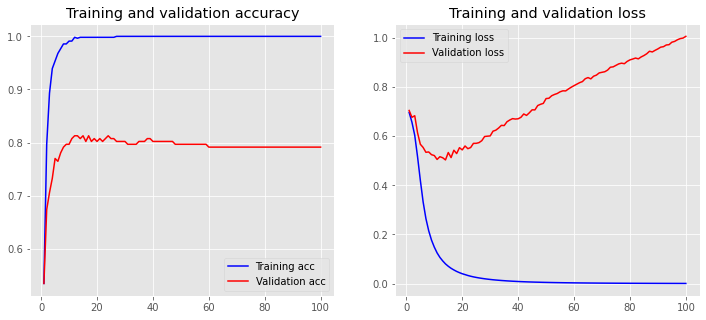

In [96]:
plot_history(history)

## What Is a Word Embedding?

Text is considered a form of sequence data similar to time series data that you would have in weather data or financial data. Now you will see how to represent each word as vectors. There are various ways to vectorize text, such as:

* Words represented by each word as a vector
* Characters represented by each character as a vector
* N-grams of words/characters represented as a vector (N-grams are overlapping groups of multiple succeeding words/characters in the text)

Here, you’ll see how to deal with representing words as vectors which is the common way to use text in neural networks. Two possible ways to represent a word as a vector are one-hot encoding and word embeddings.

**One-Hot Encoding**

The first way to represent a word as a vector is by creating a so-called one-hot encoding, which is simply done by taking a vector of the length of the vocabulary with an entry for each word in the corpus.

In this way, you have for each word, given it has a spot in the vocabulary, a vector with zeros everywhere except for the corresponding spot for the word which is set to one.

In [99]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

`LabelEncoder` to encode the list of cities into categorical integer values

In [98]:
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

OneHotEncoder expects each categorical value to be in a separate row, so you’ll need to reshape the array, then you can apply the encoder:

In [100]:
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

**Word Embeddings**

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for text preprocessing and sequence preprocessing which you can employ to prepare your text.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kept.

In [101]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


In [104]:
len(X_train)

561

In [112]:
allsentences_length = [len(x) for x in sentences]
print('min={}, mean={}, median={}, max={}'.format(   np.min(allsentences_length) ,
                                                     np.mean(allsentences_length) ,
                                                  np.median(allsentences_length) ,
                                                  np.max(allsentences_length) ) )

min=7, mean=110.98663101604278, median=72.0, max=7944


In [113]:
#

In [105]:
for word in ['the', 'all','fan']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
fan: 932


** pad sequences with Keras**

In [114]:
maxlen = 120

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


### Keras Embedding Layer

Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:
* **input_dim**: the size of the vocabulary
* **output_dim**: the size of the dense vector
* **input_length**: the length of the sequence

With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

In [119]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 50)           128750    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                60010     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 188,771
Trainable params: 188,771
Non-trainable params: 0
_________________________________________________________________


In [123]:
print(X_train.shape)
resdf

(561, 120)


,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796000
1,lr,amazon,NA,0.796000
2,lr,imdb,NA,0.748663
3,seq_dnn1,imdb,13.2073,0.791444


Training Accuracy: 1.0000
Testing Accuracy:  0.6952


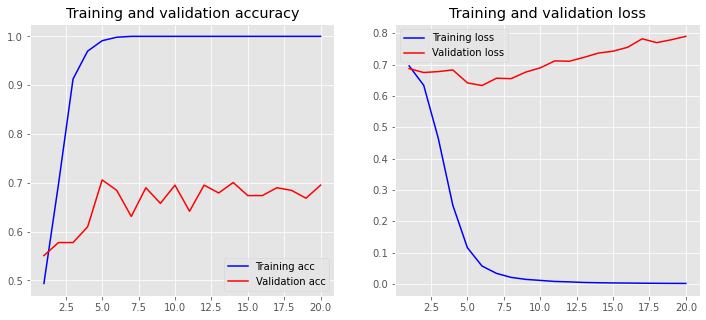

In [124]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

In [125]:
resdf.loc[idx]=['seq_dnn2_emb','imdb50',rtime, accuracy]
idx+=1
resdf


,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796000
1,lr,amazon,NA,0.796000
2,lr,imdb,NA,0.748663
3,seq_dnn1,imdb,13.2073,0.791444
4,seq_dnn2_emb,imdb50,13.2073,0.695187


Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [132]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 50)           128750    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7861


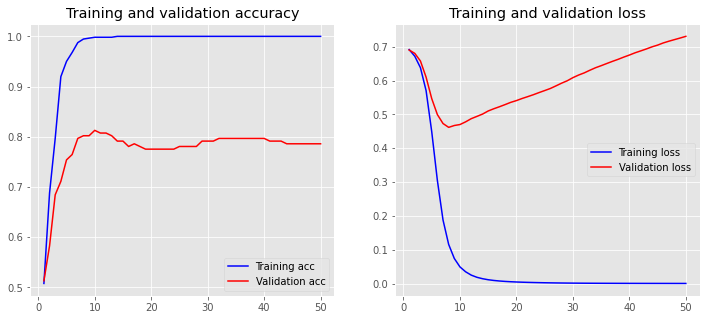

In [133]:
start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
runtime = time.time() - start_time

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [137]:
idx=5

In [138]:
resdf.loc[idx]=['seq_dnn2_emb50_maxPool','imdb',rtime, accuracy]
idx+=1
resdf

,model,dataset,Train_Runtime,accuracy
0,lr,yelp,0.025213,0.796000
1,lr,amazon,NA,0.796000
2,lr,imdb,NA,0.748663
3,seq_dnn1,imdb,13.2073,0.791444
4,seq_dnn2_emb,imdb50,13.2073,0.695187
5,seq_dnn2_emb50_maxPool,imdb,13.2073,0.786096


## Convolutional Neural Networks (CNN)

Convolutional neural networks or also called **convnets** are one of the most exciting developments in machine learning in recent years.

They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

In [129]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 100)          257500    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7754


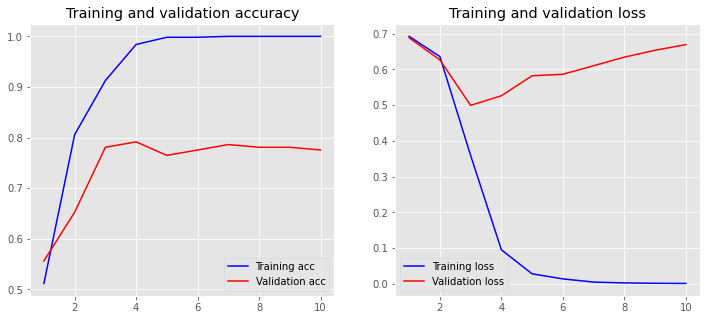

In [130]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
resdf.loc[idx]=['convnet_emb100_maxPool','imdb',rtime, accuracy]
idx+=1
resdf

## Hyperparameters Optimization

One crucial steps of deep learning and working with neural networks is hyperparameter optimization.

As you saw in the models that we have used so far, even with simpler ones, you had a large number of parameters to tweak and choose from. Those parameters are called hyperparameters. This is the most time consuming part of machine learning and sadly there are no one-fits-all solutions ready.

One popular method for hyperparameter optimization is **grid search**. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way,**random search**, which you’ll see in action here, simply takes random combinations of parameters.

In order to apply random search with Keras, you will need to use the KerasClassifier which serves as a wrapper for the scikit-learn API. With this wrapper you are able to use the various tools available with scikit-learn like cross-validation. The class that you need is RandomizedSearchCV which implements random search with cross-validation. Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data sets.

There are various types of cross-validation. One type is the k-fold cross-validation. In this type the data set is partitioned into k equal sized sets where one set is used for testing and the rest of the partitions are used for training. This enables you to run k different runs, where each partition is once used as a testing set. So, the higher k is the more accurate the model evaluation is, but the smaller each testing set is.

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
#     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
#     if prompt.lower() not in {'y', 'true', 'yes'}:
#         break
#     with open(output_file, 'w+') as f:
    s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        source,
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
#         f.write(output_string)